In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

import copy

from my_bootstrap import calculate_statistics_with_errors

In [2]:
m1 = 'd'

m2 =  mpl.markers.MarkerStyle(marker=m1)
m2._transform = m2.get_transform().rotate_deg(90)

In [3]:
def plot_free_energies1(exp, sim, labels_sim, title=None, colors=None, markers=None,
                       two_greyed_regions=True, manual_lims=None, figsize=None):
    """
    This function will plot the results in a square scatter plot
    
    """

    fontsize = 24 
    
    if figsize is None:
        figsize = [9,9]
    fig, axes = plt.subplots(ncols=1, nrows=1, figsize =figsize)
    
    def plot_errorbar(ax, x, y, y_err, color, label, zorder, alpha, marker = 's'):
        markers, caps, bars = ax.errorbar(x, y, y_err, 
                                          fmt=marker, markersize = 8,
                                          color = color, mec = color,
                                          ecolor = color, label = label,
                                          capthick=1.5, capsize=4, linewidth = 3,
                                          zorder=zorder, alpha = alpha
                                         )
        [bar.set_alpha(1) for bar in bars]
        [cap.set_alpha(1) for cap in caps]

    for i, (s, label) in enumerate(zip(sim, labels_sim)):
        print (label)
        plot_errorbar(axes, exp, s[0], s[1], color = colors[i],
                      label = label, zorder = 10+i, alpha = 1, marker = markers[i])

    leg = axes.legend(loc = 'best', fontsize=fontsize, fancybox=True)
    leg.get_frame().set_edgecolor('black')

    x = np.linspace(-100, 100, 50)

    plt.plot(x, x, color = 'black')
    plt.plot(x, x-4.185, color = 'lightgrey')
    plt.plot(x, x+4.185, color = 'lightgrey')
    #
    plt.fill_between(x, x-4.185, x+4.185, color='lightgrey')

    if two_greyed_regions:
        plt.fill_between(x, x-2*4.185, x+2*4.185, color='lightgrey', alpha=0.5)

    if title is not None:
        plt.title(title, fontsize = 18)

    plt.xlabel(r'$\Delta G_{bind}$ - Experimental [kJ/mol]', fontsize = fontsize)
    plt.ylabel(r'$\Delta G_{bind}$ - RE-EDS [kJ/mol]', fontsize = fontsize)


    axes.set_ylim(manual_lims)
    axes.set_xlim(manual_lims)
    # Formatting
    for axis in ['top','bottom','left','right']:
        axes.spines[axis].set_linewidth(1.5)

    axes.tick_params(axis="y",direction="in", length = 6, width = 1.5, labelsize=fontsize)
    axes.tick_params(axis="x",direction="in", length = 6, width = 1.5, labelsize=fontsize)
    
    axes.set_box_aspect(1)
    
    return fig, axes

def format_for_latex_table(stats):
    """
    Used to write the data down in the tables
    """
    string = f'{stats[1][0]:.1f} [{stats[1][1]:.2f} -- {stats[1][2]:.2f}] & ' 
    string += f'{stats[0][0]:.1f} [{stats[0][1]:.2f} -- {stats[0][2]:.2f}] & ' 
    string += f'{stats[3][0]:.1f} [{stats[3][1]:.2f} -- {stats[3][2]:.2f}] & ' 
    string += f'{stats[2][0]:.1f} [{stats[2][1]:.2f} -- {stats[2][2]:.2f}] \\\\' 
    print (string)
    
def offset_comparison(dgs_exp, alch_dg_complex, alch_dg_water):
    """
    This function performs a direct comparison where the simulated delta_G values for 
    all states are calculated and offset by following the procedure described in:
    
    in eq. 2 of https://pubs.acs.org/doi/10.1021/acs.jctc.6b01141
     
    Here this hence returns N data points corresponding to dGs
    
    The error bars for state 1 are calculated as the average of all other errors. 
    
    
    Args
    -----
        ic50s:
            list of ic50s
        alch_dg_complex:
            list of alchemical deltaGs (1->1, 1->2, ..., 1->N) (average and standard deviations) in complex
        alch_dg_water
            list of alchemical deltaGs (1->1, 1->2, ..., 1->N) (average and standard deviations) in water
    
    Returns
    -------
        ddgs_exp, ddgs_sim
    """
    # Simulated vales
    ddgs_binding = alch_dg_complex - alch_dg_water
   
    # Offsetting all data points 
    n = len(ddgs_binding)
    dgs_binding = ddgs_binding - (np.sum(ddgs_binding) / n - np.sum(dgs_exp) / n )
   
    return dgs_binding

def realign_with_exp(dgs_exp, dgs_sim):
    # Offsetting all data points 
    n = len(dgs_sim)
    return dgs_sim - (np.sum(dgs_sim) / n - np.sum(dgs_exp) / n )

def combine_with_pka_corr(dgs_sim_deprot, f_prot_deprot, f_prot_deprot_comp):
    """
    Combines protonated and deprotonated free energies.
    
    Equation in companion paper (https://pubs.acs.org/doi/full/10.1021/acs.jctc.8b00825)
    
    Note the minus sign (because we work from the single ligand here and not from a ddG)
    
    """
    RT = 2.479 #kj/mol
    pka_corr = - RT * np.log ( (f_prot_deprot_comp + 1) / (f_prot_deprot + 1) )
    print (f'{pka_corr=}')
    return dgs_sim_deprot + pka_corr

def combine_tautomers_4x(dgs_n, dgs_c, pkas, w, pH = 7.4):
    """
    This function will combine the binding free energies for the four 
    taumeric states 1n, 1c, and 2n, 2c (n = neutral, c = charged)
    
    dg_all_tautomers = dg_1n + correction_term
    
    see equation 24 in https://pubs.acs.org/doi/full/10.1021/acs.jctc.8b00826
    
    
    # Again note the sign change because we are correcting a dG and not the 
    second term (subtracted term) of a ddG.
    
    Arguments
    ---------
    dgs_n
        Binding free energies calculated for both tautomeric forms (when neutral)  
    dgs_c 
        Binding free energies calculated for both tautomeric forms (when charged) 
    pkas
        pKa of the two forms 
    w
        Relative weight between both tautomers
    
    """
    RT = 2.479 #kj/mol
    
    numerator = np.power(10, pkas[0] - pH) + w * ( np.power(10, pkas[1]- pH) + 1) + 1
    
    ddgs_charge = dgs_c - dgs_n
    ddg_1_2 = dgs_n[1] - dgs_n[0]
    
    denominator_a = np.exp(-ddgs_charge[0]/RT) * np.power(10, pkas[0] - pH)
    denominator_b = np.exp(-ddg_1_2/RT) * w * ( np.exp(-ddgs_charge[1]/RT) * np.power(10, pkas[1] - pH) + 1) + 1

    denominator = denominator_a + denominator_b
    
    corr = RT * np.log(numerator/denominator)
    
    return dgs_n[0] + corr

# Load the free energies from files

In [5]:
basedir = '../data/FXA/'

In [6]:
path_solv = f'{basedir}/ligands/'

dgs_solv_all_seeds = np.array([np.load(f'{path_solv}/deltaGs_seed{i}.npy') for i in range(1, 6)])

dgs_solv = np.mean(np.array(dgs_solv_all_seeds), axis = 0)
dgs_solv_err = np.std(np.array(dgs_solv_all_seeds), axis = 0)

In [7]:
path_complex = f'{basedir}/complex/'

dgs_complex_all_seeds = np.array([np.load(f'{path_complex}/deltaGs_seed{i}.npy') for i in range(1, 6)])

dgs_complex = np.mean(np.array(dgs_complex_all_seeds), axis = 0)
dgs_complex_err = np.std(np.array(dgs_complex_all_seeds), axis = 0)

In [8]:
dgs_exp = np.array([-10.71, -12.15, -12.15, -11.11, -7.75, -9.38, -11.70, -11.47]) * 4.184 
dgs_exp

array([-44.81064, -50.8356 , -50.8356 , -46.48424, -32.426  , -39.24592,
       -48.9528 , -47.99048])

In [9]:
dgs_err = np.sqrt(np.power(dgs_complex_err, 2) + np.power(dgs_solv_err, 2))

In [10]:
pH = 7.4
RT = 2.479

dgs_exp_16 = np.array([-10.71, -10.71, -12.15, -12.15, -12.15, -12.15, -11.11,  -11.11, 
                -7.75,  -7.75, -9.38, -9.38, -11.70, -11.70, -11.47, -11.47]) * 4.184 

dgs_all  = offset_comparison(dgs_exp_16, dgs_complex, dgs_solv)

idx = [0, 2, 3, 4, 5, 6, 7]

dgs_exp2 = copy.copy(dgs_exp[idx])

dgs_prot = dgs_all[::2] 
dgs_deprot = dgs_all[1::2]

dgs_err_prot = dgs_err[::2]
dgs_err_deprot = dgs_err[1::2]

## Correction terms

In [11]:
correction_terms = np.array([-13.18, -17.76, -13.26, -7.06, -17.75, -21.55, -30.37, -19.81])

### Make a plot to compare the free energies of the individual states before application of any correction, and after the application of the terms based on either (the average) or each individual correction term

In [12]:
def plot_free_energies_combined_fig(axes, exp, sim, labels_sim, title=None, colors=None, markers=None,
                       two_greyed_regions=True, manual_lims=None, figsize=None,legend_loc='lower center'):
    """
    This function will plot the results in a square scatter plot
    
    """

    fontsize = 24 
    
    def plot_errorbar(ax, x, y, y_err, color, label, zorder, alpha, marker = 's'):
        markers, caps, bars = ax.errorbar(x, y, y_err, 
                                          fmt=marker, markersize = 6,
                                          color = color, mec = 'black',
                                          ecolor = color, label = label,
                                          capthick=1.5, capsize=4, linewidth = 3,
                                          zorder=zorder, alpha = alpha
                                         )
        [bar.set_alpha(1) for bar in bars]
        [cap.set_alpha(1) for cap in caps]

    for i, (s, label) in enumerate(zip(sim, labels_sim)):
        plot_errorbar(axes, exp[i], s[0], s[1], color = colors[i],
                      label = label, zorder = 10, alpha = 1, marker = markers[i])

    leg = axes.legend(loc = legend_loc, fontsize=fontsize/1.25, fancybox=True)
    leg.get_frame().set_edgecolor('black')

    x = np.linspace(-100, 100, 50)

    axes.plot(x, x, color = 'black')
    axes.plot(x, x-4.185, color = 'lightgrey')
    axes.plot(x, x+4.185, color = 'lightgrey')
    #
    axes.fill_between(x, x-4.185, x+4.185, color='lightgrey')

    if two_greyed_regions:
        axes.fill_between(x, x-2*4.185, x+2*4.185, color='lightgrey', alpha=0.5)

    if title is not None:
        axes.set_title(title, fontsize = 18)

    axes.set_xlabel(r'$\Delta G_{bind}$ - Experimental [kJ/mol]', fontsize = fontsize)
    #axes.set_ylabel(r'$\Delta G_{bind}$ - RE-EDS [kJ/mol]', fontsize = fontsize)


    axes.set_ylim(manual_lims)
    axes.set_xlim(manual_lims)
    # Formatting
    for axis in ['top','bottom','left','right']:
        axes.spines[axis].set_linewidth(1.5)

    axes.tick_params(axis="y",direction="in", length = 6, width = 1.5, labelsize=fontsize)
    axes.tick_params(axis="x",direction="in", length = 6, width = 1.5, labelsize=fontsize)
    
    # axes.set_box_aspect(1)
    
    return None 

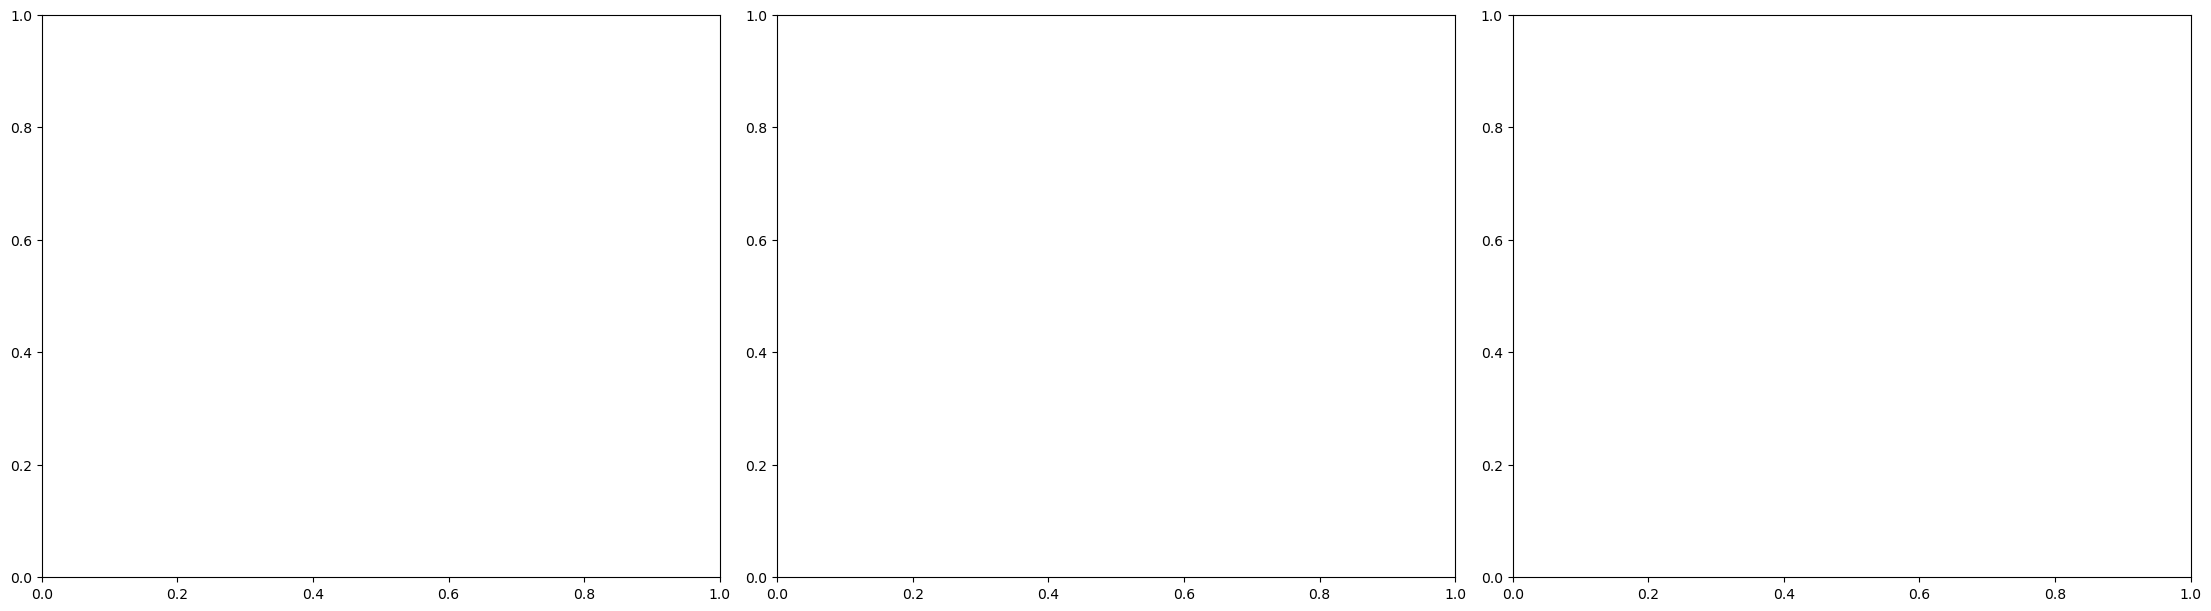

In [13]:
mosaic = """
    ABC
    """

def identify_axes(ax_dict, fontsize=48):
    kw = dict(ha="center", va="center", fontsize=fontsize, color="darkgrey")
    for k, ax in ax_dict.items():
        ax.text(0.5, 0.5, k, transform=ax.transAxes, **kw)


fig = plt.figure(layout="constrained", figsize = [22, 6])
ax_dict = fig.subplot_mosaic(mosaic)
#| identify_axes(ax_dict)

In [14]:
tmp_prot = np.array([dgs_prot, dgs_err_prot])
tmp_deprot = np.array([dgs_deprot, dgs_err_deprot])

plot_free_energies_combined_fig(ax_dict['A'], [dgs_exp, dgs_exp], 
                                [tmp_prot, tmp_deprot],
                                labels_sim = ['protonated', 'deprotonated'],
                                markers = ['D', 'D'],
                                colors =  ['#BB1177', '#3388CC', ],
                                manual_lims = [-60, -25],
                                #title='Independent protonation states', 
                                legend_loc = 'lower right'
                               )

ax_dict['A'].set_ylabel(r'$\Delta G_{bind}$ - RE-EDS [kJ/mol]', fontsize = 24)

ax_dict['A'].set_title('No corr. terms + recentered on superset', fontsize = 24)

ax_dict['A'].set_box_aspect(1)

# Label the points? 
for i in range(1, 9):
    if i == 1:
        ax_dict['A'].text(dgs_exp[i-1] +0.5, tmp_prot[0][i-1] - 1.5, f'({i})', fontsize=12, fontweight='bold')
    elif i == 8 or i == 7:
        ax_dict['A'].text(dgs_exp[i-1] +0.5, tmp_prot[0][i-1] - 1.5, f'({i})', fontsize=12, fontweight='bold')
    else:
        ax_dict['A'].text(dgs_exp[i-1] -2, tmp_prot[0][i-1] - 1.5, f'({i})', fontsize=12, fontweight='bold')

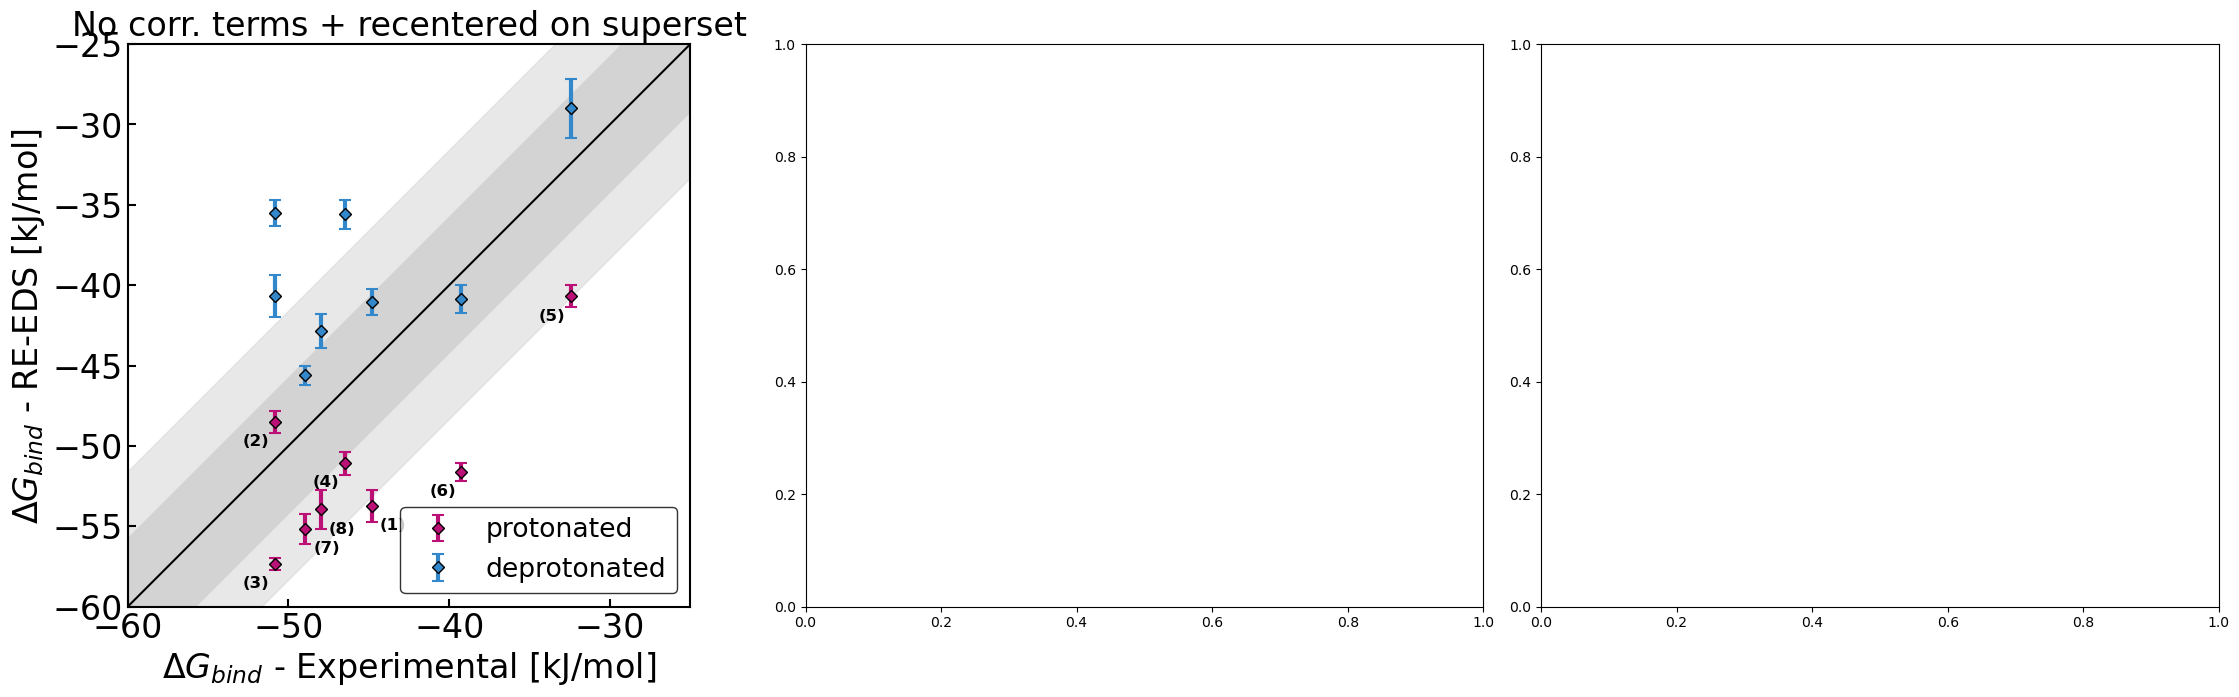

In [15]:
fig

In [16]:
dgs_corr_indiv = copy.copy(dgs_all[::2])
dgs_corr_avg = copy.copy(dgs_all[::2])

for i in range(0, 8):
    dgs_corr_indiv[i] += correction_terms[i]
    dgs_corr_avg[i] += np.average(correction_terms)
    
dgs_corr_indiv_prot = np.array([dgs_corr_indiv, dgs_err[::2]])
dgs_corr_avg_prot = np.array([dgs_corr_avg, dgs_err[::2]])


In [17]:
plot_free_energies_combined_fig(ax_dict['B'], [dgs_exp, dgs_exp, dgs_exp], 
                                [tmp_prot, dgs_corr_indiv_prot, dgs_corr_avg_prot],
                                labels_sim = ['prot (no corr.)', 'prot (individual)', 'prot (average)'],
                                markers = ['D', 'o', 'o'],
                                colors =  ['#BB1177', 'darkorange', 'black'],
                                manual_lims = [-90, -35],
                                #title='Independent protonation states', 
                                legend_loc = 'lower right'
                               )
ax_dict['B'].set_xlim([-60, -25])
ax_dict['B'].set_title('Applying correction terms', fontsize = 24)

ax_dict['B'].arrow(-55, -55, 0, -15, width = 0.5, color = 'black')

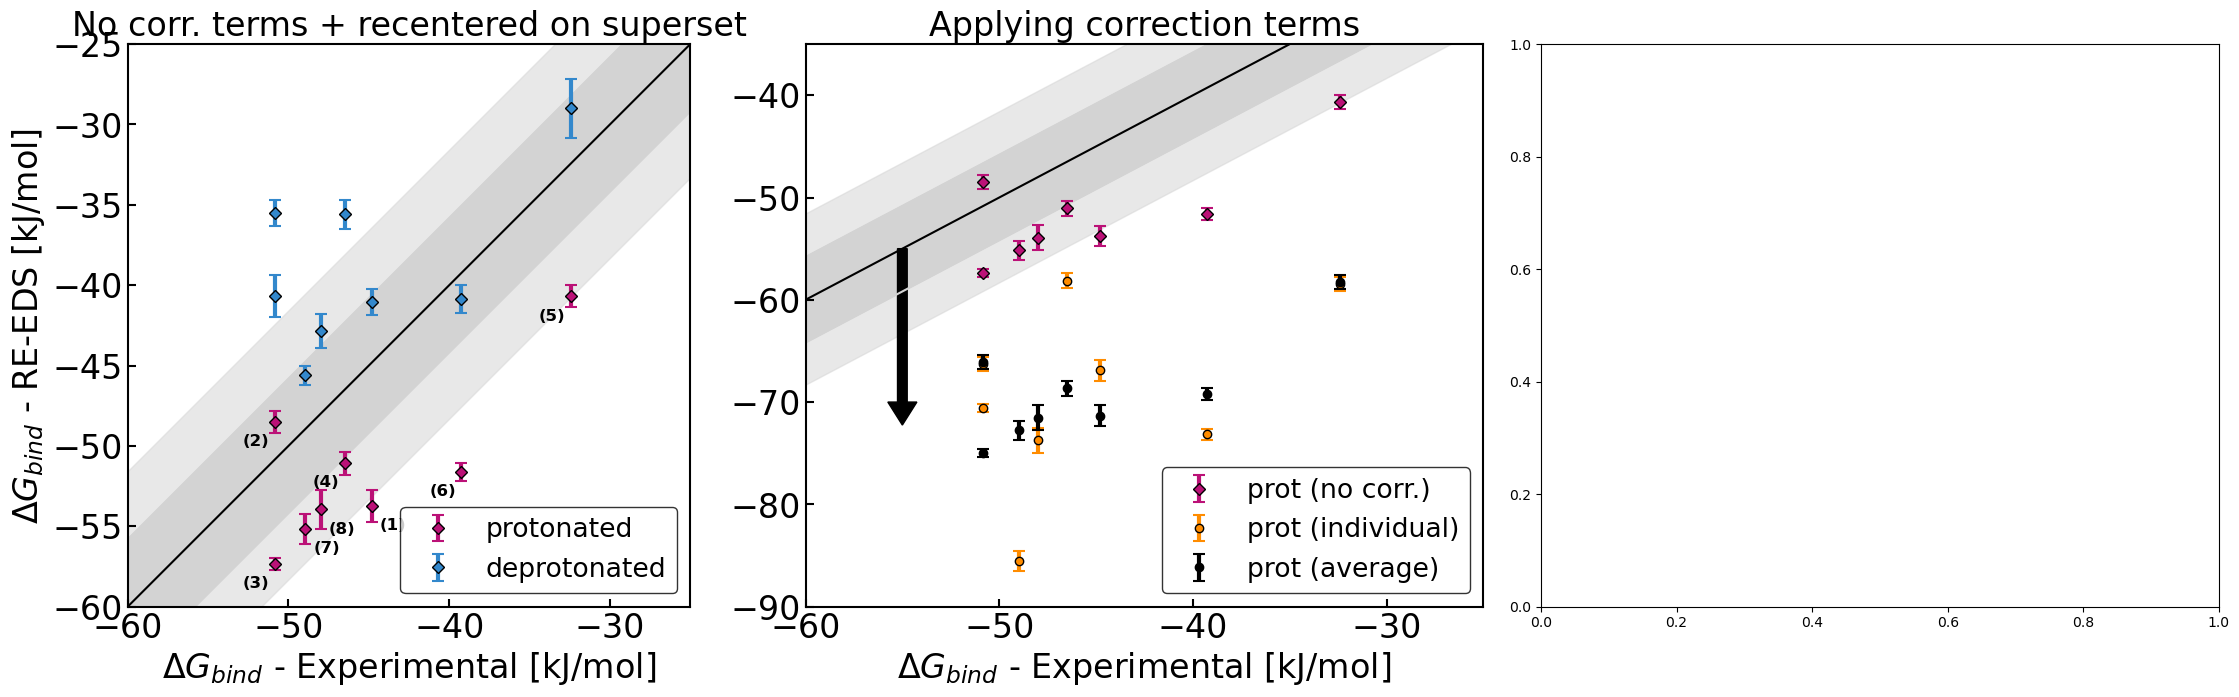

In [18]:
fig

In [19]:
realigned_prot = np.array([realign_with_exp(dgs_exp, tmp_prot[0]), dgs_err_prot])
realigned_corr_indiv_prot = np.array([realign_with_exp(dgs_exp, dgs_corr_indiv), dgs_err_prot])
realigned_corr_avg_prot = np.array([realign_with_exp(dgs_exp, dgs_corr_avg), dgs_err_prot])

plot_free_energies_combined_fig(ax_dict['C'], [dgs_exp, dgs_exp, dgs_exp], 
                                [realigned_prot, realigned_corr_indiv_prot, realigned_corr_avg_prot],
                                labels_sim = ['prot (no corr.)', 'prot (individual)', 'prot (average)'],
                                markers = ['D', 'o', 'o'],
                                colors =  ['#BB1177', 'darkorange', 'black'],
                                #manual_lims = [-90, -35],
                                #title='Independent protonation states', 
                                legend_loc = 'lower right'
                               )
ax_dict['C'].set_ylim([-65, -25])
ax_dict['C'].set_xlim([-65, -25])
ax_dict['C'].set_box_aspect(1)

ax_dict['C'].set_title('Correction terms + recentering', fontsize = 24)

Text(0.5, 1.0, 'Correction terms + recentering')

In [20]:
ax_dict['A'].text(-58.5, -28.5, 'A',fontsize=36, fontweight='bold')
ax_dict['B'].text(-58.5, -40.5, 'B',fontsize=36, fontweight='bold')
ax_dict['C'].text(-63.5, -28.5, 'C',fontsize=36, fontweight='bold')

Text(-63.5, -28.5, 'C')

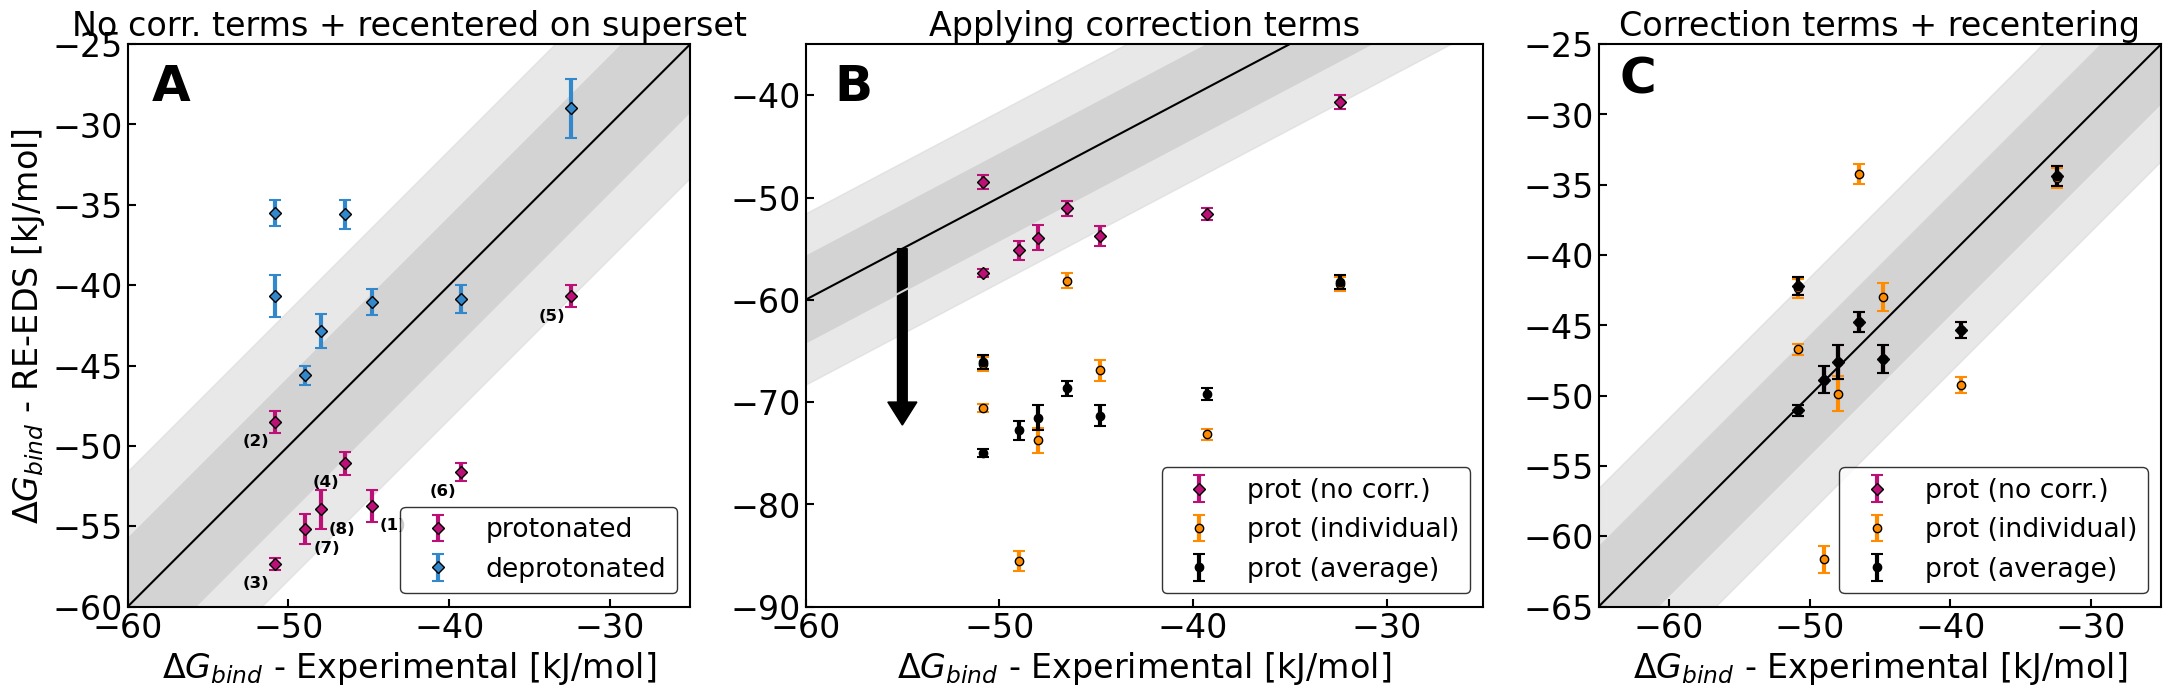

In [21]:
fig

In [22]:
# fig.savefig('/home/cchampion/Desktop/FXA_free_energies_Qcorr_effect.pdf', bbox_inches='tight', dpi=100)

### Bar plot with the deltaGs

Here I had tried to see if I could use a different representation but wasn;t really happy about it.

Text(0, 0.5, '$\\Delta{}G$ [kJ/mol]')

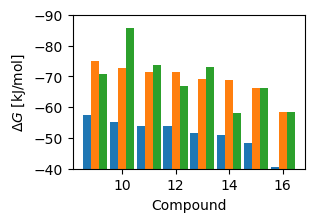

In [29]:
fig, ax = plt.subplots(figsize=[3, 2])

x = np.arange(9, 17)

tmp_prot, dgs_corr_indiv_prot, dgs_corr_avg_prot

idx = np.argsort(tmp_prot[0])

w = 0.3

ax.bar(x-w, tmp_prot[0][idx], width = w)
ax.bar(x, dgs_corr_avg_prot[0][idx], width = w)
ax.bar(x+w, dgs_corr_indiv_prot[0][idx], width = w)

ax.set_ylim([-40, -90])

ax.set_xlabel('Compound')
ax.set_ylabel(r'$\Delta{}G$ [kJ/mol]')

# Now try combining together with the larger separation 

In [98]:
pH = 7.4
RT = 2.479

dgs_exp_16 = np.array([-10.71, -10.71, -12.15, -12.15, -12.15, -12.15, -11.11,  -11.11, 
                -7.75,  -7.75, -9.38, -9.38, -11.70, -11.70, -11.47, -11.47]) * 4.184 

dgs_all  = offset_comparison(dgs_exp_16, dgs_complex, dgs_solv)

idx = [0, 2, 3, 4, 5, 6, 7]

dgs_exp2 = copy.copy(dgs_exp[idx])

# Use either of the two following lines:
dgs_prot = dgs_all[::2] + correction_terms 
#dgs_prot = dgs_all[::2] + np.average(correction_terms)
dgs_deprot = dgs_all[1::2]

dgs_err_prot = dgs_err[::2]
dgs_err_deprot = dgs_err[1::2]

ddgs_lig = dgs_prot - dgs_deprot

print (ddgs_lig)

pkas = np.array([6.51, 7.05, 6.67, 8.21, 7.2, 6.77, 7.35, 7.44])

pkas_complex = pkas - (ddgs_lig) / (RT * np.log(10))


frac_prot_deprot = np.power(10, pkas - pH)
frac_prot_deprot_comp = np.power(10, pkas_complex - pH)

#print (f'{frac_prot_deprot=}')
print (f'{frac_prot_deprot_comp=}')

dgs_corr_jaguar = combine_with_pka_corr(dgs_deprot, frac_prot_deprot, frac_prot_deprot_comp)

dgs_err_jaguar= np.sqrt(np.power(dgs_err_prot, 2) + np.power(dgs_err_deprot, 2))
dgs_combined_jaguar = np.array([realign_with_exp(dgs_exp, dgs_corr_jaguar), dgs_err_jaguar])


#
#
# And combine all four tautomers 
#
#

pkas_for_tautomer = pkas[1:3]

dgs_prot_for_tautomer = dgs_prot[1:3]
dgs_deprot_for_tautomer = dgs_deprot[1:3]

micro_pka1 = 1.8
micro_pka2 = 1.2

t2_t1 = 10**(micro_pka2-pH) / 10**(micro_pka1-pH) 

# fraction of the two tautomeric forms obtained from micro pKas
w = t2_t1 # very close to (16+3) / (56+25) # ~ four times more of tautomer 1 than tautomer 2

dg_tautomer_jaguar = combine_tautomers_4x(dgs_deprot_for_tautomer, dgs_prot_for_tautomer, pkas_for_tautomer, w)

dgs_sim_tautomer = copy.copy(dgs_corr_jaguar[idx])
dgs_sim_tautomer[1] = dg_tautomer_jaguar

err_tautomer_jaguar = dgs_err_jaguar[idx]
err_tautomer_jaguar[1] = np.sqrt(np.sum(np.power(dgs_err_jaguar[[1,2]], 2)))

dgs_combined_jaguar2 = np.array([realign_with_exp(dgs_exp2, dgs_sim_tautomer), err_tautomer_jaguar])

# print (f'{dg_tautomer_jaguar=}')

[-25.87683912 -30.76538264 -29.9237639  -22.54892906 -29.44130964
 -32.32778928 -39.93906648 -30.90732364]
frac_prot_deprot_comp=array([4.39893449e+03, 1.09589367e+05, 3.25331227e+04, 5.75881308e+04,
       9.07412771e+04, 1.08015350e+05, 8.84912720e+06, 2.84862300e+05])
pka_corr=array([-20.49678774, -27.85213765, -25.33360127, -22.19200136,
       -27.08706985, -28.20961769, -38.07394714, -29.30055489])


# Plotting The combined free energies

In [99]:
def plot_errorbar(ax, x, y, y_err, color, label, zorder, alpha, marker):
    markers, caps, bars = ax.errorbar(x, y, y_err, marker=marker, markersize = 8,
                                      color = color, mec = color,
                                      ecolor = color, label = label,
                                      capthick=1.5, capsize=4, linewidth = 3,
                                      zorder=zorder, alpha = alpha, ls = ''
                                     )

In [100]:
dgs_combined_jaguar2

array([[-39.58769304, -42.12635665, -35.83525875, -34.14670696,
        -47.10819785, -61.73310186, -50.20836488],
       [  1.27538565,   1.72371532,   1.14625397,   1.97554827,
          1.04867779,   1.11713941,   1.60252306]])

In [101]:
dgs_prot

array([-66.90620324, -66.27234404, -70.61278307, -58.13064527,
       -58.43940556, -73.16482826, -85.53668001, -73.75359243])

protonated (no corr.)
combined


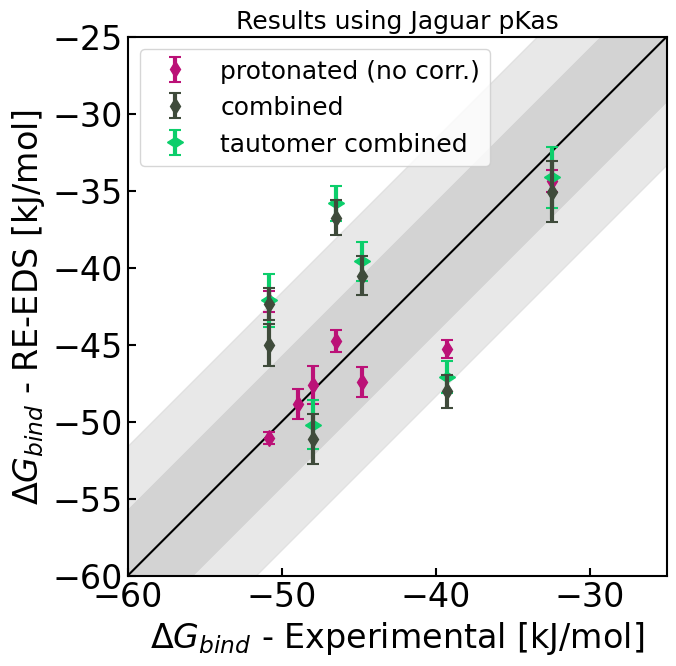

In [102]:


fig, axes = plot_free_energies1(dgs_exp, 
                                [ realigned_prot, dgs_combined_jaguar], 
                                labels_sim = ['protonated (no corr.)', 'combined'],
                                markers = [m1, m1],
                                colors = ['#BB1177', '#3F4B3B'],
                                manual_lims = [-60, -25])

plot_errorbar(axes, dgs_exp2, dgs_combined_jaguar2[0], dgs_combined_jaguar2[1], 
              color = '#0CCE6B', label = 'tautomer combined', zorder = 10, alpha = 1, marker = m2, )

axes.set_title('Results using Jaguar pKas', fontsize = 18)


axes.legend(fontsize=18)

fig.set_figheight(7)
fig.set_figwidth(7)

In [106]:
# fig.savefig('/home/cchampion/Desktop/FXA_free_energies_Qcorr_indiv.pdf', bbox_inches='tight', dpi = 100)

In [104]:
x =calculate_statistics_with_errors(dgs_exp, dgs_combined_jaguar[0], dgs_combined_jaguar[1], )
print (x)
print ('\n')
y = calculate_statistics_with_errors(dgs_exp2, dgs_combined_jaguar2[0], dgs_combined_jaguar2[1])
print (y)

((11.96, 10.85, 13.27), (7.08, 6.18, 8.01), (0.44, 0.26, 0.5), (0.33, 0.18, 0.4))


((12.24, 11.04, 13.83), (7.02, 6.2, 8.08), (0.57, 0.32, 0.57), (0.43, 0.24, 0.43))


In [105]:
format_for_latex_table(x)
format_for_latex_table(y)

7.1 [6.18 -- 8.01] & 12.0 [10.85 -- 13.27] & 0.3 [0.18 -- 0.40] & 0.4 [0.26 -- 0.50] \\
7.0 [6.20 -- 8.08] & 12.2 [11.04 -- 13.83] & 0.4 [0.24 -- 0.43] & 0.6 [0.32 -- 0.57] \\
